In [3]:
import cProfile
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.datasets import make_blobs

from hcluster.singlelink import SingleLinkClust

In [11]:
def scipy_linkage(df, n_clust):
    linkage_matrix = linkage(df)
    labels = fcluster(linkage_matrix, n_clust, criterion="maxclust")
    
    return labels

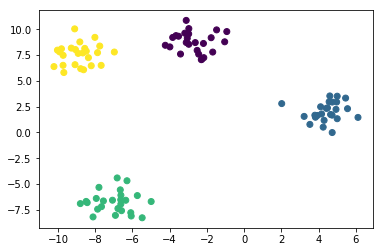

In [12]:
data, y = make_blobs(n_samples=100, n_features=2, centers=4, random_state=42)
plt.scatter(data[:, 0], data[:, 1], c=y)

In [13]:
scipy_labels = scipy_linkage(data, 4)

In [14]:
scipy_labels

array([4, 1, 3, 1, 4, 1, 2, 2, 2, 3, 3, 1, 1, 2, 3, 4, 4, 2, 4, 4, 3, 4,
       4, 2, 2, 3, 2, 4, 4, 1, 1, 2, 1, 4, 3, 3, 3, 3, 2, 2, 4, 2, 1, 3,
       3, 1, 1, 4, 4, 2, 2, 2, 2, 1, 4, 4, 3, 3, 2, 3, 1, 2, 4, 1, 4, 4,
       1, 4, 2, 1, 2, 1, 4, 3, 1, 4, 1, 4, 1, 1, 2, 1, 3, 4, 3, 3, 3, 1,
       3, 2, 2, 1, 3, 1, 3, 3, 3, 2, 4, 2], dtype=int32)

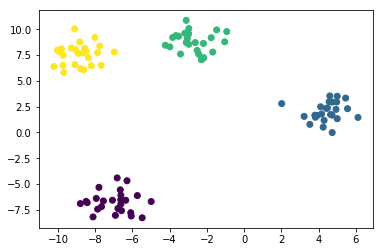

In [15]:
plt.scatter(data[:, 0], data[:, 1], c=scipy_labels)

In [16]:
model = SingleLinkClust(4)

In [18]:
labels = model.fit_predict(data)

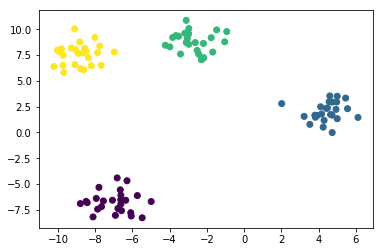

In [19]:
plt.scatter(data[:, 0], data[:, 1], c=scipy_labels)